## Relax Take Home Challenge
---

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [82]:
users = pd.read_csv('takehome_users.csv', encoding='ansi', index_col='object_id')
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [20]:
user_eng = pd.read_csv('takehome_user_engagement.csv', encoding='utf-8')
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [22]:
# Convert time_stamp column to date time
user_eng['time_stamp'] = user_eng['time_stamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [31]:
# Find all users over 3 visited logins
active_users = user_eng.groupby('user_id').sum()
active_users = active_users[active_users['visited'] >= 3]
active_users_list = active_users.index

In [44]:
# Filter users that have logged in at least 3 times within 7 day time window
adopted = []

for user in active_users_list:

    ser = user_eng['time_stamp'][user_eng['user_id'] == user]
    
    start = 0
    ct = 0
    delta = 0

    for dt in ser:

        if start == 0:
            start = dt
            delta = start + timedelta(days=7)
            ct = 1
        else:
            if dt <= delta:
                ct += 1
            else:
                start = 0

        if ct == 3:
            adopted.append(user)
            break

In [83]:
# Add column to indicate adopted users in main users dataframe
users['adopted_user'] = 0
for user_id in users.index:
    if user_id in adopted:
        users.loc[user_id, 'adopted_user'] = 1

In [84]:
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [143]:
users.adopted_user.describe()

count    12000.000000
mean         0.128750
std          0.334937
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: adopted_user, dtype: float64

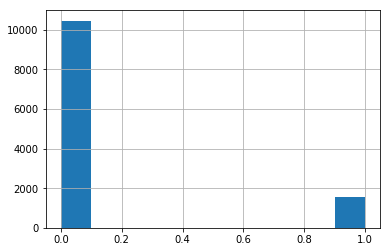

In [140]:
users.adopted_user.hist()
plt.show()

In [58]:
users.last_session_creation_time.describe()

count    8.823000e+03
mean     1.379279e+09
std      1.953116e+07
min      1.338452e+09
25%      1.363195e+09
50%      1.382888e+09
75%      1.398443e+09
max      1.402067e+09
Name: last_session_creation_time, dtype: float64

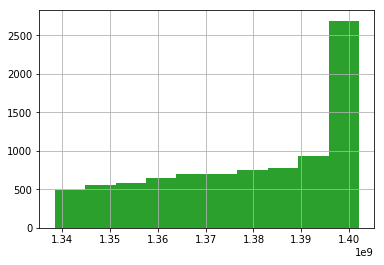

In [63]:
users.last_session_creation_time.hist()
plt.show()

In [66]:
last_created_mode = users.last_session_creation_time.mode()[0]
last_created_mode

1401868018.0

In [132]:
df = users.copy()

# Fill NaN values
df['invited_by_user_id'].fillna(0, inplace=True)
df.loc[df['invited_by_user_id'].notnull(), 'invited_by_user_id'] = 1

df['last_session_creation_time'].fillna(last_created_mode, inplace=True)

# Scale number down
df['last_session_creation_time'] = df['last_session_creation_time'].div(10**9)

# Convert to datetime
df['creation_time'] = df['creation_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Convert creation time to days int
max_time = df['creation_time'].max()
df['creation_time'] = df['creation_time'].apply(lambda x: (max_time - x).days)

# Email address converted to just hosted address
df['email'] = df['email'].str.split('@').str[1]

# Drop name column
df.drop('name', axis=1, inplace=True)

# Change org column to categorical
df['org_id'] = df['org_id'].astype('category')

In [134]:
df_dum = pd.get_dummies(df)
df_dum.columns

Index(['creation_time', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'invited_by_user_id', 'adopted_user', 'email_abdnf.com',
       'email_adpql.com', 'email_aerbd.com', 'email_aethf.com',
       ...
       'org_id_407', 'org_id_408', 'org_id_409', 'org_id_410', 'org_id_411',
       'org_id_412', 'org_id_413', 'org_id_414', 'org_id_415', 'org_id_416'],
      dtype='object', length=1612)

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import itertools

In [136]:
X = df_dum.drop(['adopted_user'], axis=1)
y = df_dum['adopted_user']

In [104]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [173]:
def model_report(model, X, y, title, weight=None):
    """Takes in classifier model with X data and class weight to display scores and confusion matrix."""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1111, stratify=y)
    
    clf = model(class_weight=weight, random_state=1111)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    class_names = ['Not_Adopt', 'Adopt']
    
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Average Precision: {:.2f}'.format(average_precision_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred, target_names=class_names))

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
      
    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title=title)
    plt.show()
    
    return clf

Accuracy: 0.87
Average Precision: 0.13
             precision    recall  f1-score   support

  Not_Adopt       0.87      1.00      0.93      3137
      Adopt       0.00      0.00      0.00       463

avg / total       0.76      0.87      0.81      3600

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


C:\Users\seung\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


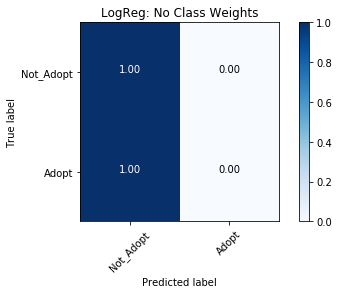

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1111, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
model_report(LogisticRegression, X, y,'LogReg: No Class Weights')

Accuracy: 0.66
Average Precision: 0.16
             precision    recall  f1-score   support

  Not_Adopt       0.91      0.68      0.78      3137
      Adopt       0.19      0.52      0.28       463

avg / total       0.81      0.66      0.71      3600

Normalized confusion matrix
[[0.68 0.32]
 [0.48 0.52]]


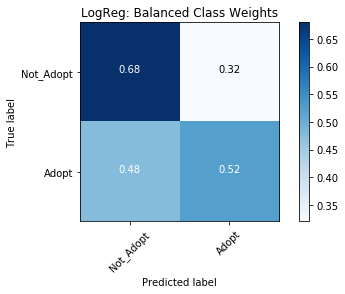

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1111,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [175]:
model_report(LogisticRegression, X, y,'LogReg: Balanced Class Weights', 'balanced')

Accuracy: 0.94
Average Precision: 0.57
             precision    recall  f1-score   support

  Not_Adopt       0.94      0.99      0.96      3137
      Adopt       0.93      0.55      0.69       463

avg / total       0.94      0.94      0.93      3600

Normalized confusion matrix
[[0.99 0.01]
 [0.45 0.55]]


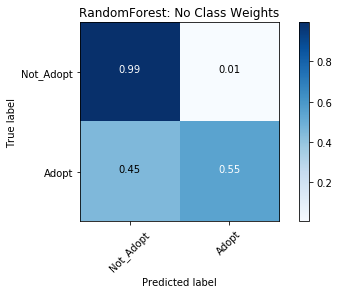

In [158]:
res = model_report(RandomForestClassifier, X, y,'RandomForest: No Class Weights')

Accuracy: 0.94
Average Precision: 0.59
             precision    recall  f1-score   support

  Not_Adopt       0.94      0.99      0.97      3137
      Adopt       0.94      0.56      0.70       463

avg / total       0.94      0.94      0.93      3600

Normalized confusion matrix
[[0.99 0.01]
 [0.44 0.56]]


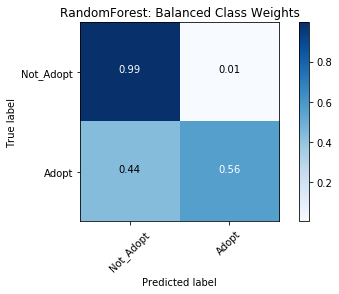

In [159]:
res2 = model_report(RandomForestClassifier, X, y,'RandomForest: Balanced Class Weights', 'balanced')

In [168]:
feat_impt = list(zip(X.columns, res.feature_importances_))

def getKey(item):
    return item[1]

sorted(feat_impt, key=getKey, reverse=True)

[('last_session_creation_time', 0.3627021642978535),
 ('creation_time', 0.11580980801628911),
 ('creation_source_SIGNUP_GOOGLE_AUTH', 0.017754527378087106),
 ('creation_source_ORG_INVITE', 0.016700213531424382),
 ('opted_in_to_mailing_list', 0.011659299494492927),
 ('creation_source_SIGNUP', 0.011484509650863329),
 ('enabled_for_marketing_drip', 0.010943174257652082),
 ('email_gmail.com', 0.010796253375262934),
 ('creation_source_PERSONAL_PROJECTS', 0.009425465860605504),
 ('creation_source_GUEST_INVITE', 0.008728157111873431),
 ('email_yahoo.com', 0.008264789583433765),
 ('email_hotmail.com', 0.007150297894446493),
 ('email_cuvox.de', 0.006574727816287085),
 ('email_jourrapide.com', 0.0063872683541763954),
 ('email_gustr.com', 0.0062665018250784394),
 ('org_id_235', 0.003449329609826867),
 ('org_id_306', 0.0031020125529220297),
 ('org_id_2', 0.0027705268810334035),
 ('org_id_141', 0.002732583976398515),
 ('org_id_0', 0.002507473435823133),
 ('org_id_19', 0.00245636230556785),
 ('org_i